In [1]:
import os
import csv
import math
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import platereadertools as pr

from sklearn.decomposition import PCA    
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

import embedNregress_v1 as enr

# Import Data

In [2]:
now = datetime.now()
date = now.strftime('%Y%m%d')
time = now.strftime('%H%M%S')


data_fp = "Data/"
spacer_fp = os.path.join(data_fp, "GFP_spacers.gbk")
data_0nM_fp = os.path.join(data_fp,
                            "p2x11_80memberlibrary_0mMIPTG20230730.txt")
data_10mM_fp = os.path.join(data_fp,
                            "p2x11_80memberlib_10mMIPTG20230730.txt")

seqs = csv.reader(open("Data/GFP_spacers.csv"))
allseqs = [seq for seq in seqs]

NumRowsonPlate = 8
NumColumnsonPlate = 12
HourHorizon = 18
SamplingRate = 3/60; 
data0, time0 = pr.Organize(data_0nM_fp,NumRowsonPlate,NumColumnsonPlate,HourHorizon,SamplingRate)
data1, time1 = pr.Organize(data_10mM_fp,NumRowsonPlate,NumColumnsonPlate,HourHorizon,SamplingRate)

OD_key = list(data0.keys())[0]
FL_key = list(data0.keys())[1]

odfloor = 0.01
baseline_od_data = data0[OD_key]
baseline_fl_data = data0[FL_key]
induced_od_data = data1[OD_key]
induced_fl_data = data1[FL_key]

# Define the Horizon for Use in Testing and Training and Format Data.
Note that the horizon is the secion of the timeseries trace which we are interested in.

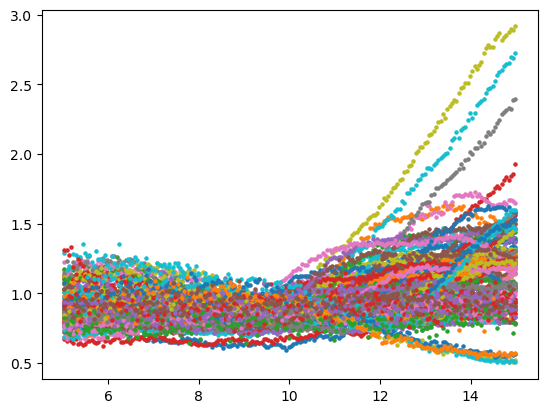

In [3]:
StartHorizon = 100 # these are in unit of timepoints not time
EndHorizon= 300

time_vec = time0[FL_key][StartHorizon:EndHorizon]
foldchangedata = np.zeros((8,12,EndHorizon-StartHorizon))
for row in range(0,8):
    for col in range(0,12):
        #print(induced_fl_data.shape)
        #print(time_vec.shape)
        odnormfl_induced = induced_fl_data[row][col][StartHorizon:EndHorizon]/(induced_od_data[row][col][StartHorizon:EndHorizon]+odfloor)
        odnormfl_baseline = baseline_fl_data[row][col][StartHorizon:EndHorizon]/(baseline_od_data[row][col][StartHorizon:EndHorizon]+odfloor)
        this_foldchange = odnormfl_induced/odnormfl_baseline  #fold change for a particular row, col combination 
        foldchangedata[row,col,:] = this_foldchange

        plt.scatter(time_vec,this_foldchange, s=5)

listed_foldchangedata = foldchangedata.reshape(int(foldchangedata.shape[0]*foldchangedata.shape[1]),foldchangedata.shape[2])

# Check the Foldchange Data

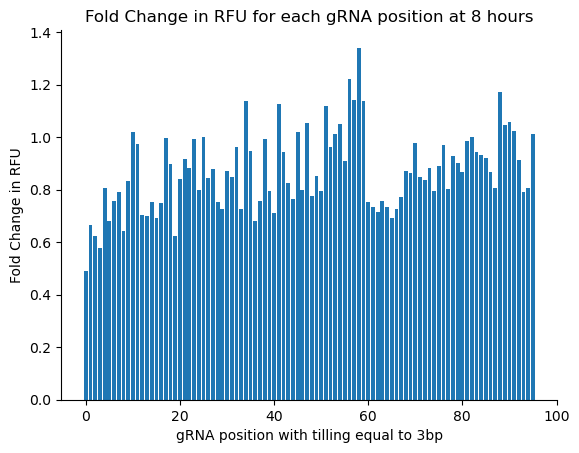

In [4]:
# Based off of the timeseries data, we can see that the greatest change in flourescence occurs at timepoint 165 
# (~8hours). We will use this timepoint to calculate the fold change between the 0mM and 10mM data.
reads = list(data0.keys())
data_pt0 = data0[reads[1]][:,:,165]
data_pt1 = data1[reads[1]][:,:,165]
# Calculate the fold change between the 0mM and 10mM data.
fold_change = data_pt1/data_pt0
data = np.reshape(fold_change,(96))
# Visualize the foldchange to see if there are any trends.
explore = True
save = False
if explore:
    fig, ax = plt.subplots(1,1)
    ax.bar(range(len(data)), data)
    ax.set_xlabel("gRNA position with tilling equal to 3bp")
    ax.set_ylabel('Fold Change in RFU')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_title("Fold Change in RFU for each gRNA position at 8 hours")

    if save:    
        plt.savefig(f"/home/yeunglab/AlecOutputData/foldchange.png")

# Define Model Parameters

### Auto-Encoder Parameters

In [5]:
stride_parameter = 30 #Determinded by the length of the gRNA sequence
label_dim = EndHorizon-StartHorizon # To match the number of timepoints in the plate reader data
embedding_dim = 18 #18 was a good dimension for embedding Alec's gRNA sequences that resulted in near perfect reconstruction 
batch_size_parameter = 20 
n_pre_post_layers = 10
lambda_var = 0.1 #Dertermines when to focus on training the feed forward network.

### FeedForward Parameters

In [6]:
feedforwardDepth = 10
feedforwardDim = 20
intermediate_dim = 50
outpuDim = EndHorizon-StartHorizon

### Training Parameters

In [7]:
debug_splash = 0
this_step_size_val = 0.05
this_max_iters = 1e6

# Initialize and Format Data.

In [8]:
this_corpus,this_labels = enr.make_labeled_corpus(allseqs, data, stride_parameter)
Rand_Transform = enr.rvs(dim=stride_parameter)

this_corpus_vec = []
for this_corpus_elem in this_corpus:
    vec_value = enr.sequence_encoding(this_corpus_elem)
    vec_value = np.dot(Rand_Transform,vec_value)
    this_corpus_vec.append(vec_value)

this_corpus_vec = np.asarray(this_corpus_vec) 

# Define Session, Assemble Network, and Train.

In [9]:
train_flag = True

hidden_vars_list = [intermediate_dim]*n_pre_post_layers+[embedding_dim]+[intermediate_dim]*n_pre_post_layers+[stride_parameter]

sess = tf.compat.v1.Session()
tf.compat.v1.disable_eager_execution() 

# Embedding Newtork (Autoencoder)
this_regress_y_labels = tf.compat.v1.placeholder(tf.float32,shape=[None,outpuDim])
this_u = tf.compat.v1.placeholder(tf.float32, shape=[None,stride_parameter])
this_regress_y_labels = tf.compat.v1.placeholder(tf.float32,shape=[None,outpuDim])
with tf.device('/cpu:0'):
    this_W_list,this_b_list = enr.initialize_Wblist(stride_parameter, hidden_vars_list)
    this_y_out, all_layers = enr.network_assemble(this_u, this_W_list, this_b_list, keep_prob=1.0, activation_flag=2, res_net=0)

# Regression Network (Feedforward)
this_embedding = all_layers[n_pre_post_layers]
regress_list = [feedforwardDim]*feedforwardDepth+[outpuDim]
with tf.device('/cpu:0'):
    this_Wregress_list,this_bregress_list = enr.initialize_Wblist(embedding_dim, regress_list)
    try:
        this_regress_y,all_regress_layers = enr.network_assemble(this_embedding ,this_Wregress_list, this_bregress_list)
    
    except:
        embedding_dimension = this_embedding.shape
        print(f"Warning: Assembly Failed, embedding dimension shape is: {this_embedding.shape}")
    HybridLoss = enr.customRegressLoss(this_y_out, this_u, this_embedding, this_regress_y, this_regress_y_labels)
    this_optim = tf.compat.v1.train.AdagradOptimizer(learning_rate=this_step_size_val).minimize(HybridLoss)
    step_size = tf.compat.v1.placeholder(tf.float32,shape=[])
    result = sess.run(tf.compat.v1.global_variables_initializer())
    this_ae_loss = enr.ae_loss(this_y_out,this_u)
    this_embed_loss = enr.embed_loss(this_u,this_embedding)

    if train_flag:
        # Train the network
        train_figure_name = f"Figures/Training{embedding_dim}_{intermediate_dim}_{stride_parameter}_{n_pre_post_layers}.png"
            
        enr.train_net(sess, this_corpus_vec,this_u,listed_foldchangedata,this_regress_y_labels,HybridLoss,
                this_optim,
                this_ae_loss=this_ae_loss,
                this_embed_loss=this_embed_loss,  
                batchsize=batch_size_parameter,
                step_size_val=this_step_size_val,
                max_iters=this_max_iters,
                save_fig= train_figure_name)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


2024-10-25 12:33:03.698132: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


 step 1 , validation error 1.56853
 step 1 , test error 1.53999
 Reconstruction Loss: 0.92990285
 Embedding Loss: 0.10209619
 step 1000 , validation error 0.507143
 step 1000 , test error 0.209488
 Reconstruction Loss: 0.10268912
 Embedding Loss: 0.1880708
 step 2000 , validation error 0.578382
 step 2000 , test error 0.179117
 Reconstruction Loss: 0.10205406
 Embedding Loss: 0.20181355
 step 3000 , validation error 0.580947
 step 3000 , test error 0.167547
 Reconstruction Loss: 0.08878444
 Embedding Loss: 0.1917154
 step 4000 , validation error 0.481513
 step 4000 , test error 0.152415
 Reconstruction Loss: 0.08237193
 Embedding Loss: 0.19878799
 step 5000 , validation error 0.52471
 step 5000 , test error 0.152106
 Reconstruction Loss: 0.07897113
 Embedding Loss: 0.19469021
 step 6000 , validation error 0.508446
 step 6000 , test error 0.146745
 Reconstruction Loss: 0.07413159
 Embedding Loss: 0.190903
 step 7000 , validation error 0.384459
 step 7000 , test error 0.142585
 Reconstru

# Save This Version of the Model 

In [10]:
saver = tf.compat.v1.train.Saver()
save_path = saver.save(sess, f'saved_models/{date}_{time}')

# Check Mismatches

Predicted:'TTGATCTCCT
Ground Truth:'TTGATCTCCT'


Predicted:'TTTCATTGTT
Ground Truth:'TTTCATTGTT'


Predicted:'AAAATTGCTT
Ground Truth:'AAAATTGCTT'


Predicted:'TCAGTACGAA
Ground Truth:'TCAGTACGAA'


Predicted:'AAGATGTTTC
Ground Truth:'AAGATGTTTC'


Predicted:'GCATGATTAA
Ground Truth:'GCATGATTAA'


Predicted:'CCTCCCCTGC
Ground Truth:'CCTCCCCTGC'


Predicted:'TTAGAAACCC
Ground Truth:'TTAGAAACCC'


Predicted:'AAGCTCCATT
Ground Truth:'AAGCTCCATT'


Predicted:'CCAGTGAAAA
Ground Truth:'CCAGTGAAAA'


Predicted:'GAACAACGCC
Ground Truth:'GAACAACGCC'


Predicted:'CAGGATGGGA
Ground Truth:'CAGGATGGGA'


Predicted:'AGCTCGACCA
Ground Truth:'AGCTCGACCA'


Predicted:'CGCCGTCCAG
Ground Truth:'CGCCGTCCAG'


Predicted:'GTTTACGTCG
Ground Truth:'GTTTACGTCG'


Predicted:'TTGTGGCCGT
Ground Truth:'TTGTGGCCGT'


Predicted:'CGCTGAACTT
Ground Truth:'CGCTGAACTT'


Predicted:'GCCGGACACG
Ground Truth:'GCCGGACACG'


Predicted:'TCGCCCTCGC
Ground Truth:'TCGCCCTCGC'


Predicted:'CATCGCCCTC
Ground Truth:'CATCGCCCTC'




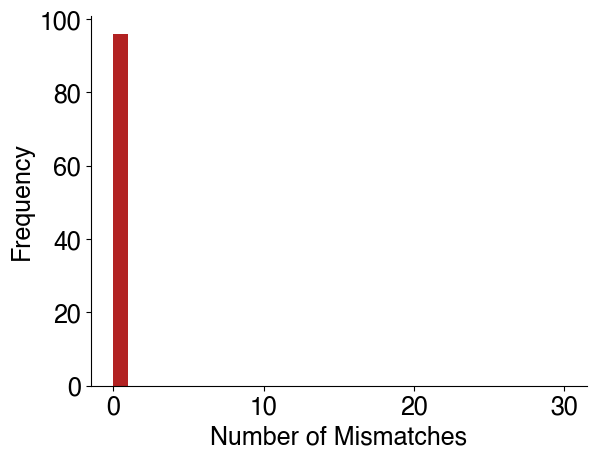

In [11]:
plt.rcParams.update({'font.family':'Helvetica', 'font.size': 18})

all_mismatches = []
for ind in range(0,len(this_corpus_vec)):
    z_ind = this_y_out.eval(feed_dict={this_u:[this_corpus_vec[ind]]}, session=sess)
    this_seq_out = enr.vecback2seq(np.dot(np.linalg.inv(Rand_Transform), z_ind.T))
    print("Predicted:"+repr("".join(this_seq_out))[0:11])
    print("Ground Truth:"+repr("".join(this_corpus[ind][0:10])))
    print("\n")
    this_seq_out = ''.join(this_seq_out)
    all_mismatches.append(enr.num_mismatch(this_seq_out, this_corpus[ind]))

mismatch_process = np.array(all_mismatches)
np.sum(mismatch_process)/(len(mismatch_process)*1.0)
fig, ax = plt.subplots(1,1)
ax.hist(mismatch_process, bins=range(0,31,1), color= 'firebrick')
ax.set_xlabel("Number of Mismatches")
ax.set_ylabel("Frequency")
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
#ax.set_title("Number of Mismatches in Predicted Sequences")
plt.savefig(f"Figures/mismatches{date}_{time}.png")

# Check Clustering Using PCA.

PCA Explained Variance Ratio: array([0.70818293, 0.124832  , 0.09453443], dtype=float32)
PCA Singular Values: array([55.72996 , 23.398014, 20.361559], dtype=float32)


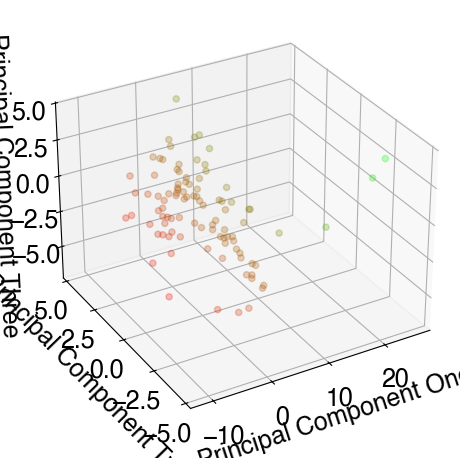

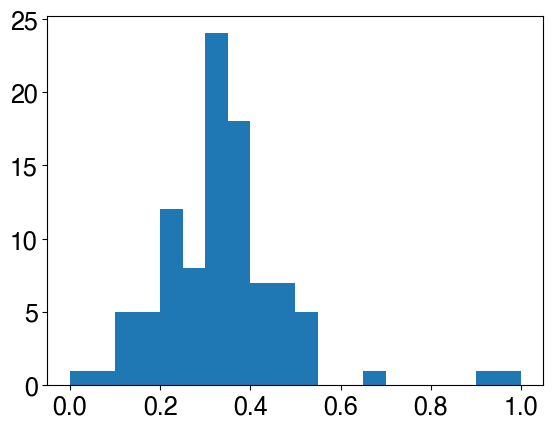

In [12]:
subset_embeddings = this_embedding.eval(feed_dict={this_u:this_corpus_vec},
                                        session=sess)
X = subset_embeddings
pca = PCA(n_components=3)
pca.fit(X)
PCA(copy=True, iterated_power='auto', n_components=3, random_state=None,
svd_solver='auto', tol=0.0, whiten=False)

print("PCA Explained Variance Ratio: " + repr(pca.explained_variance_ratio_))
print("PCA Singular Values: " + repr(pca.singular_values_))

X_transformed = pca.transform(X)
X_transformed = X_transformed[0:]

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

this_colors = 0*np.random.rand(len(X_transformed), 6)

foldchange_colorscale = np.sum(np.abs(listed_foldchangedata),axis=1)

foldchange_colorscale = (foldchange_colorscale-np.min(foldchange_colorscale))/np.max(foldchange_colorscale-np.min(foldchange_colorscale))

rgb_scheme = np.zeros((len(X_transformed),3))
for x_ind in range(0,len(X_transformed)):
    rgb_scheme[x_ind,0] = 1.0-foldchange_colorscale[x_ind]
    rgb_scheme[x_ind,1] = foldchange_colorscale[x_ind]

ax.scatter(X_transformed[:,0], X_transformed[:,1],X_transformed[:,2],
            c=rgb_scheme, marker='o',alpha=0.25)
ax.view_init(30, azim=240)
ax.set_xlabel('Principal Component One')
ax.set_ylabel('Principal Component Two')
ax.set_zlabel('Principal Component Three')
plt.tight_layout()
fig.savefig(f"Figures/PCA{date}_{time}.png")

fig2 = plt.figure()
plt.hist(foldchange_colorscale,bins=20)
fig2.savefig(f"Figures/Hist{date}_{time}.png")